## External Imports

In [1]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

try:
    import optuna
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
import argparse
# import sympy as sy
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this
import ipywidgets as wid; wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Import utils

In [3]:
try:
    IQN_BASE = os.environ['IQN_BASE']
    print('BASE directoy properly set = ', IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
    print('data directory also properly set, in %s' % os.environ['DATA_DIR'])
except Exception:
    print("""BASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do os.environ['IQN_BASE']='/home/ali/Desktop/Pulled_Github_Repositories/torchQN'""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
data directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


## Set arguments and configurations

In [4]:
################################### ARGUMENTS ###############################
parser=argparse.ArgumentParser(description='train for different targets')
parser.add_argument('--N', type=str, help='size of the dataset you want to use. Options are 10M and 100K and 10M_2, the default is 10M_2', required=False,default='10M_2')
#N_epochs X N_train_examples = N_iterations X batch_size
# N_iterations = (N_epochs * train_data.shape[0])/batch_size
#N_iterations = (N_epochs * train_data.shape[0])/64 = 125000 for 1 epoch
parser.add_argument('--n_iterations', type=int, help='The number of iterations for training, the default is', required=False,default=50)
#default=5000000 )
parser.add_argument('--n_layers', type=int, help='The number of layers in your NN, the default is 5', required=False,default=6)
parser.add_argument('--n_hidden', type=int, help='The number of hidden layers in your NN, the default is 5', required=False,default=6)
parser.add_argument('--starting_learning_rate', type=float, help='Starting learning rate, the defulat is 10^-3', required=False,default=1.e-2)
parser.add_argument('--show_loss_plots', type=bool, help='Boolean to show the loss plots, default is False', required=False,default=False)
parser.add_argument('--save_model', type=bool, help='Boolean to save the trained model dictionary', required=False,default=False)
parser.add_argument('--save_loss_plots', type=bool, help='Boolean to save the loss plots', required=False,default=False)


############################################################## CONFIGURATIONS ##########
DATA_DIR=os.environ['DATA_DIR']
JUPYTER=True

if JUPYTER:
    args = parser.parse_args(args=[])
    N = '10M_2'
    n_iterations = int(50)
    n_layers, n_hidden = int(1), int(10)
    starting_learning_rate = float(1.e-2)
    show_loss_plots = False
    save_model=False
    save_loss_plots = False
else:
    args = parser.parse_args()
    N = args.N
    n_iterations = args.n_iterations
    n_layers = args.n_layers
    n_hidden = args.n_hidden
    starting_learning_rate=args.starting_learning_rate
    show_loss_plots=args.show_loss_plots
    save_model=args.save_model
    save_loss_plots=args.save_loss_plots




### Import the numpy data, convert to dataframe and save (if you haven't saved)

# Explore the Dataframe and preprocess

In [79]:
all_variable_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']
all_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'tau']
train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'))
# test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'))
train_data=train_data[all_cols]
train_data.describe()

,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
count,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06
mean,3.269523e+01,-1.781882e-03,-3.830903e-04,6.962994e+00,3.286720e+01,-1.789886e-03,-4.719170e-04,5.555567e+00,4.999153e-01
std,1.493793e+01,2.204310e+00,1.813825e+00,2.781332e+00,1.582936e+01,2.197969e+00,1.814474e+00,2.664340e+00,2.886730e-01
min,2.000000e+01,-5.227320e+00,-3.141590e+00,-7.042220e-04,1.144390e+01,-5.006930e+00,-3.480195e+00,-8.631670e-05,5.075658e-08
25%,2.376670e+01,-1.654600e+00,-1.571320e+00,5.116180e+00,2.348440e+01,-1.651130e+00,-1.571500e+00,3.805560e+00,2.498142e-01
50%,2.840240e+01,-2.726765e-03,6.159285e-05,6.537620e+00,2.898930e+01,-3.001240e-03,-4.192835e-05,5.120820e+00,4.999874e-01
75%,3.627690e+01,1.651250e+00,1.570300e+00,8.282190e+00,3.749822e+01,1.647990e+00,1.570142e+00,6.774150e+00,7.500011e-01
max,8.397820e+02,5.188200e+00,3.141590e+00,1.112440e+02,8.148800e+02,5.005230e+00,3.482885e+00,1.139730e+02,9.999999e-01


In [81]:
X       = ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

FIELDS  = {'RecoDatam' : {'inputs': X, 
                           'xlabel':  r'$m$ (GeV)', 
                           'xmin': 0, 
                           'xmax': 25},
           
           'RecoDatapT': {'inputs': ['RecoDatam']+X, 
                           'xlabel':  r'$p_T$ (GeV)' , 
                           'xmin'  : 20, 
                           'xmax'  :  80},
           
           'RecoDataeta': {'inputs': ['RecoDatam','RecoDatapT'] + X, 
                           'xlabel': r'$\eta$',
                           'xmin'  : -5,
                           'xmax'  :  5},
           
           'RecoDataphi'  : {'inputs': ['RecoDatam', 'RecodatapT', 'RecoDataeta']+X,
                           'xlabel': r'$\phi$' ,
                           'xmin'  : -3.2, 
                           'xmax'  :3.2}
          }


In [84]:
def explore_data(df, title):
    fig, ax = plt.subplots(1,4, figsize=(20,10) )
    # df = df[['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']]
    levels = ['RecoData', 'genData']
    kinematics=['pT','eta','phi','m']
    columns = [level+k for level in levels for k in kinematics]
    print(columns)
    df = df[columns]
    
    for k_i, k in enumerate(kinematics):
        Reco_var = levels[0]+k
        gen_var = levels[1]+k
        print('Reco_var', Reco_var, 'gen_var', gen_var)
        ax[k_i].hist(df[Reco_var], bins=100, label=Reco_var, alpha=0.35)
        ax[k_i].hist(df[gen_var], bins=100, label=gen_var, alpha=0.35)
        xmin, xmax = FIELDS[Reco_var]['xmin'], FIELDS[Reco_var]['xmax']
        xlabel=FIELDS[Reco_var]['xlabel']
        ax[k_i].set_xlim( (xmin, xmax) )
        ax[k_i].set_xlabel(xlabel,fontsize=26)
        
        ax[k_i].legend(loc='best', fontsize=13)
    fig.suptitle(title, fontsize=20)
    plt.tight_layout();plt.show()

['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam']
Reco_var RecoDatapT gen_var genDatapT
Reco_var RecoDataeta gen_var genDataeta
Reco_var RecoDataphi gen_var genDataphi
Reco_var RecoDatam gen_var genDatam


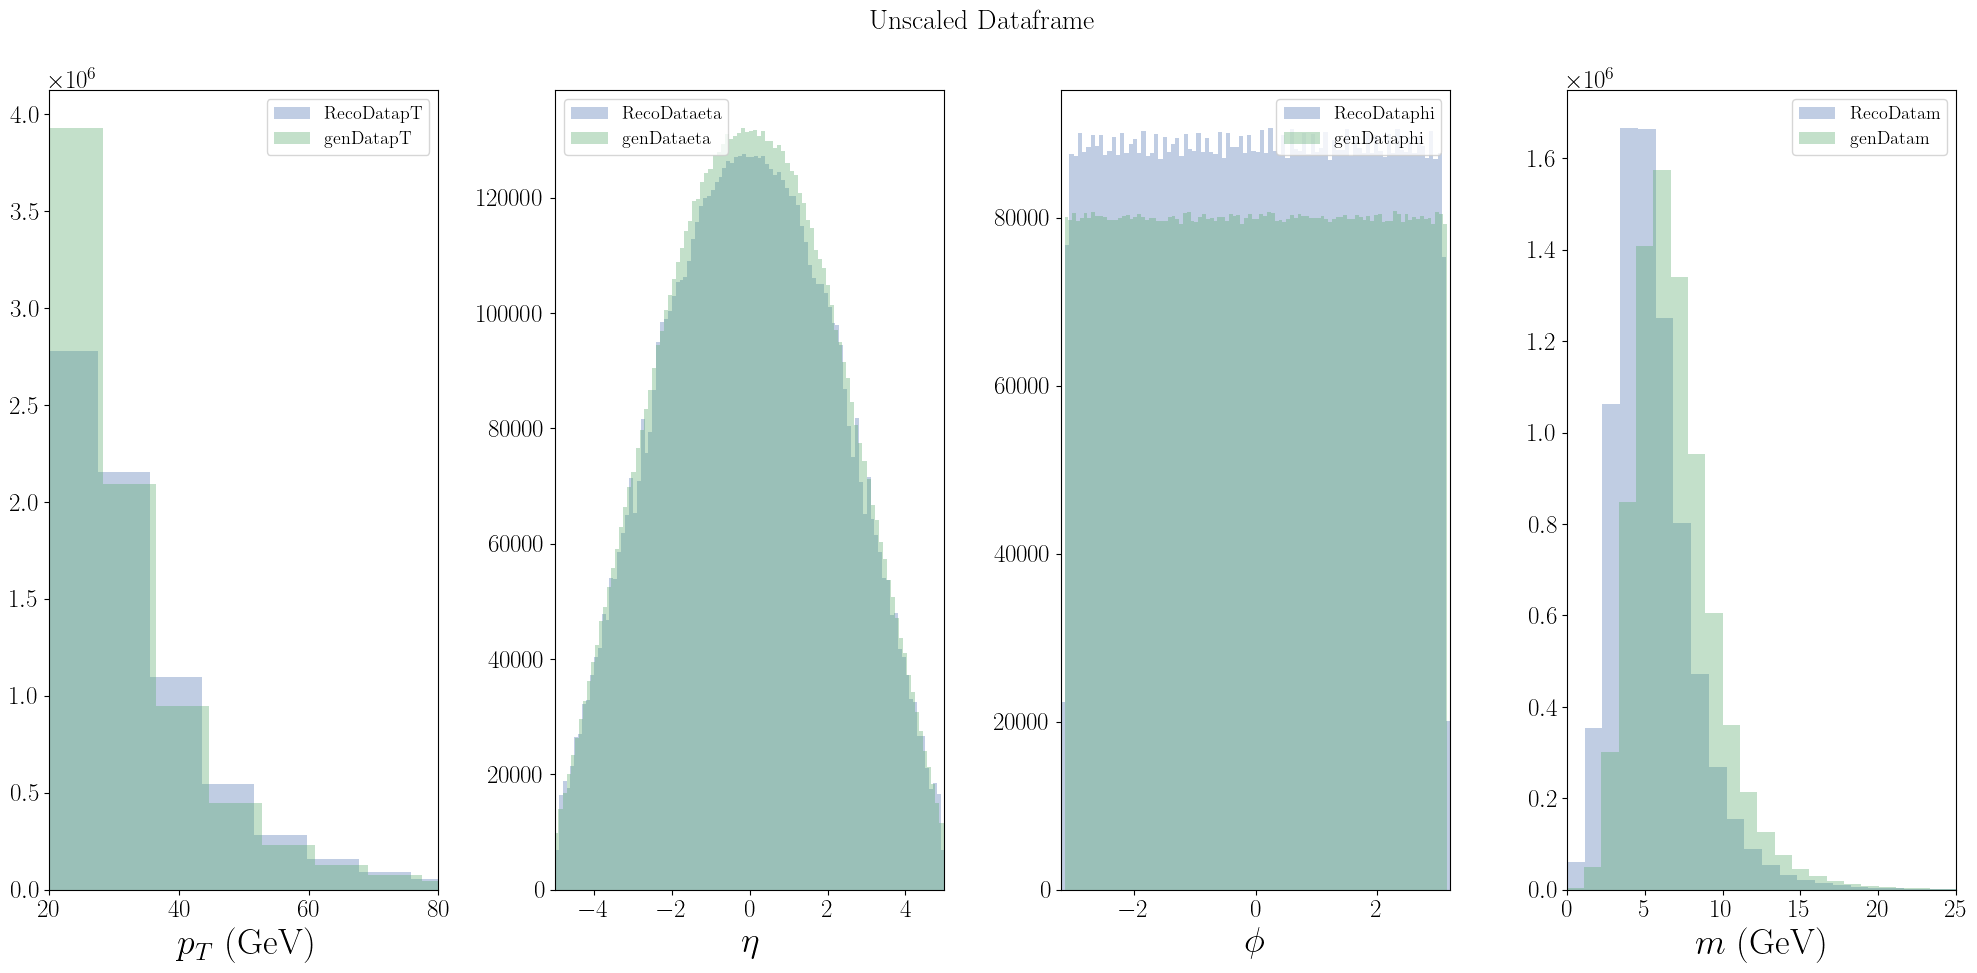

In [85]:
explore_data(train_data, title='Unscaled Dataframe')

In [96]:
def scale_df(df, title, save=False):
    #scale
    df = df[all_variable_cols]
    # print(df.head())
    scaled_df = pd.DataFrame()
    #select the columns: 0:genDatapT, 1:genDataeta, 2:genDataphi, 3:genDatam, 4:RecoDatapT, 5:RecoDataeta, 6:RecoDataphi, 7: Recodatam
    scaled_df['genDatapT'] = df.iloc[:,0]* 4
    print(scaled_df.head())
    #save scaled
    # scale_df.to_csv(os.path.join(DATA_DIR, title+'.csv') )

In [97]:
scale_df(train_data, 'l')

   genDatapT
0   117.7808
1    97.2772
2    97.2772
3    97.2772
4    80.6812


In [89]:
pd.DataFrame.iloc?

Type:        property
String form: <property object at 0x7fad36b15e30>
Docstring:  
Purely integer-location based indexing for selection by position.

``.iloc[]`` is primarily integer position based (from ``0`` to
``length-1`` of the axis), but may also be used with a boolean
array.

Allowed inputs are:

- An integer, e.g. ``5``.
- A list or array of integers, e.g. ``[4, 3, 0]``.
- A slice object with ints, e.g. ``1:7``.
- A boolean array.
- A ``callable`` function with one argument (the calling Series or
  DataFrame) and that returns valid output for indexing (one of the above).
  This is useful in method chains, when you don't have a reference to the
  calling object, but would like to base your selection on some value.

``.iloc`` will raise ``IndexError`` if a requested indexer is
out-of-bounds, except *slice* indexers which allow out-of-bounds
indexing (this conforms with python/numpy *slice* semantics).

See more at :ref:`Selection by Position <indexing.integer>`.

See Also
------

In [ ]:


target = 'RecoDatam'
source  = FIELDS[target]
features= source['inputs']
########
print('USING NEW DATASET')
train_data=pd.read_csv(DATA_DIR+'/train_data_10M_2.csv')
print('TRAINING FEATURES\n', train_data[features].head())

test_data=pd.read_csv(DATA_DIR+'/test_data_10M_2.csv')
# valid_data=pd.read_csv(DATA_DIR+'/validation_data_10M_2.csv')

print('train set shape:',  train_data.shape)
# print('validation set shape:', valid_data.shape)
print('test set shape:  ', test_data.shape)





def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t, x):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

def average_quantile_loss(f, t, x):
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    return torch.mean(torch.where(t >= f, 
                                  tau * (t - f), 
                                  (1 - tau)*(f - t)))

# function to validate model during training.
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=10, window=10):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        

y_label_dict ={'RecoDatapT':'$p(p_T)$'+' [ GeV'+'$^{-1} $'+']',
                    'RecoDataeta':'$p(\eta)$', 'RecoDataphi':'$p(\phi)$',
                    'RecoDatam':'$p(m)$'+' [ GeV'+'$^{-1} $'+']'}

loss_y_label_dict ={'RecoDatapT':'$p_T^{reco}$',
                    'RecoDataeta':'$\eta^{reco}$', 'RecoDataphi':'$\phi^{reco}$',
                    'RecoDatam':'$m^{reco}$'}


def plot_average_loss(traces, ftsize=18,save_loss_plots=save_loss_plots):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        plt.savefig('images/loss_curves/IQN_'+N+T+'_Consecutive_2.png')
        print('\nloss curve saved in images/loss_curves/IQN_'+N+target+'_Consecutive.png')
    # if show_loss_plots:
    #     plt.show()



def run(model, scalers, target, 
        train_x, train_t, 
        valid_x, valid_t, traces,
        n_batch=256, 
        n_iterations=n_iterations, 
        traces_step=500, 
        traces_window=500,
        save_model=save_model):

    learning_rate= starting_learning_rate
    optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate) 
    #starting at 10^-3	    
    traces = train(model, optimizer, 
                      average_quantile_loss,
                      get_batch,
                      train_x, train_t, 
                      valid_x, valid_t,
                      n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step, 
                  window=traces_window)
    
    # learning_rate=learning_rate/10
    # optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate) 
    # #10^-4
    # traces = train(model, optimizer, 
    #                   average_quantile_loss,
    #                   get_batch,
    #                   train_x, train_t, 
    #                   valid_x, valid_t,
    #                   n_batch, 
    #               n_iterations,
    #               traces,
    #               step=traces_step, 
    #               window=traces_window)


    # learning_rate=learning_rate/100
    # optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate) 
    # #10^-6
    # traces = train(model, optimizer, 
    #                   average_quantile_loss,
    #                   get_batch,
    #                   train_x, train_t, 
    #                   valid_x, valid_t,
    #                   n_batch, 
    #               n_iterations,
    #               traces,
    #               step=traces_step, 
    #               window=traces_window)

    # plot_average_loss(traces)

    if save_model:
        torch.save(model.state_dict(), 'trained_models/iqn_model_CONSECUTIVE10M_2_%s.dict' % target)
        print('\ntrained model dictionary saved in trained_models/iqn_model_CONSECUTIVE10M_2_%s.dict' % target)
    return utils.ModelHandler(model, scalers) 


if target== 'RecoDatapT':
    label= '$p_T$ [GeV]'
    x_min, x_max = 20, 60
elif target== 'RecoDataeta':
    label = '$\eta$'
    x_min, x_max = -5.4, 5.4
elif target =='RecoDataphi':
    label='$\phi$'
    x_min, x_max = -3.4, 3.4
elif target == 'RecoDatam':
    label = ' $m$ [GeV]'
    x_min, x_max = 0, 18




def evaluate_model(dnn, target, src,
               fgsize=(6, 6), 
               ftsize=20,save_image=False, save_pred=False,
               show_plot=True):
    eval_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'))
    ev_features=X
    #['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','tau']
    
    eval_data=eval_data[ev_features]
    
    print('EVALUATION DATA OLD INDEX\n', eval_data.head())

    

   
    y = dnn(eval_data)
    eval_data['RecoDatam']=y
    new_cols= ['RecoDatam'] + X
    eval_data=eval_data.reindex(columns=new_cols)
    print('EVALUATION DATA NEW INDEX\n', eval_data.head())

    eval_data.to_csv('AUTOREGRESSIVE_m_Prime.csv')


    if save_pred:
        pred_df = pd.DataFrame({T+'_predicted':y})
        pred_df.to_csv('predicted_data/dataset2/'+T+'_predicted_MLP_iter_5000000.csv')
        
    if save_image or show_plot:
        gfile ='fig_model_%s.png' % target
        xbins = 100
        xmin  = src['xmin']
        xmax  = src['xmax']
        xlabel= src['xlabel']
        xstep = (xmax - xmin)/xbins

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
        
        ax.set_xlim(xmin, xmax)
        ax.set_xlabel(xlabel, fontsize=ftsize)
        ax.set_xlabel('reco jet '+label, fontsize=ftsize)
        ax.set_ylabel(y_label_dict[target], fontsize=ftsize)

        ax.hist(train_data['RecoDatam'], 
                bins=xbins, 
                range=(xmin, xmax), 
                alpha=0.3, 
                color='blue', 
                density=True, 
                label='simulation')
        ax.hist(y, 
                bins=xbins, 
                range=(xmin, xmax), 
                alpha=0.3, 
                color='red', 
                density=True, 
                label='$y^\prime$')
        ax.grid()
        ax.legend()
        
        
        if save_image:
            plt.savefig('images/'+T+'IQN_Consecutive_'+N+'.png')
            print('images/'+T+'IQN_Consecutive_'+N+'.png')
        if show_plot:
            plt.tight_layout()
            plt.show()
##########
################################################CNN







def main():
    start=time.time()
    print('estimating mass\n')
    model =  utils.RegularizedRegressionModel(nfeatures=train_x.shape[1], ntargets=1,nlayers=n_layers, hidden_size=n_hidden)
    traces = ([], [], [], [])
    dnn = run(model, scalers, target, train_x, train_t, valid_x, valid_t, traces)
    evaluate_model( dnn, target, source)
    with open('m_params.json','w') as f:
        f.write(json.dumps({'n_layers':n_layers, 'n_hidden':n_hidden, 'starting_learning_rate': starting_learning_rate, 'n_iterations':n_iterations }))
    end=time.time()
    difference=end-start
    print('evaluating m took ',difference/3600, 'hours')

if __name__ == "__main__":
    main()

